In [1]:
import matplotlib.pyplot as plt

In [2]:
import os
from pathlib import Path

current_path = Path(os.getcwd())
root = current_path.parent.absolute()
os.chdir(root)

In [3]:
import pandas as pd
import numpy as np


In [9]:
columns = ['IWD','IWC','SPY','DEM','CLY']

dfs = {}

for i in range(len(columns)):
    df = pd.read_excel("data/Reinforcement Data.xlsx", usecols=str, sheet_name=columns[i])
    df = df.iloc[:, 0].str.split(',', expand=True)
    df = df.set_axis(['Date', 'Open', 'High','Low','Close','Adj Close','Volume'], axis = 1)
    df = df[['Close','Date']]
    df = df.set_index('Date')
    dfs[columns[i]] = df

dfs


{'IWD':                  Close
 Date                  
 2011-01-03   65.599998
 2011-01-04   65.690002
 2011-01-05   66.040001
 2011-01-06   65.760002
 2011-01-07   65.570000
 ...                ...
 2022-10-05  143.639999
 2022-10-06  142.020004
 2022-10-07  138.850006
 2022-10-10  137.990005
 2022-10-11  137.419998
 
 [2964 rows x 1 columns],
 'IWC':                  Close
 Date                  
 2011-01-03   51.000000
 2011-01-04   50.200001
 2011-01-05   50.950001
 2011-01-06   50.730000
 2011-01-07   50.520000
 ...                ...
 2022-10-05  108.040001
 2022-10-06  107.489998
 2022-10-07  104.220001
 2022-10-10  103.480003
 2022-10-11  103.519997
 
 [2964 rows x 1 columns],
 'SPY':                  Close
 Date                  
 2011-01-03  127.050003
 2011-01-04  126.980003
 2011-01-05  127.639999
 2011-01-06  127.389999
 2011-01-07  127.139999
 ...                ...
 2022-10-05  377.089996
 2022-10-06  373.200012
 2022-10-07  362.790009
 2022-10-10  360.019989
 2022-10-11

In [10]:
data = pd.concat([dfs['IWD'],dfs['IWC'],dfs['SPY'],dfs['DEM'],dfs['CLY']], axis = 1)
data.columns=['IWD','IWC','SPY','DEM','CLY']
data

,IWD,IWC,SPY,DEM,CLY
Date,,,,,
2011-01-03,65.599998,51.000000,127.050003,60.240002,52.980000
2011-01-04,65.690002,50.200001,126.980003,60.130001,52.669998
2011-01-05,66.040001,50.950001,127.639999,60.020000,52.029999
2011-01-06,65.760002,50.730000,127.389999,59.619999,52.480000
2011-01-07,65.570000,50.520000,127.139999,59.099998,52.709999
...,...,...,...,...,...
2022-10-05,143.639999,108.040001,377.089996,34.369999,48.750000
2022-10-06,142.020004,107.489998,373.200012,34.110001,48.669998
2022-10-07,138.850006,104.220001,362.790009,33.630001,47.990002


In [26]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [27]:
table = data

Text(0, 0.5, 'cours en $')

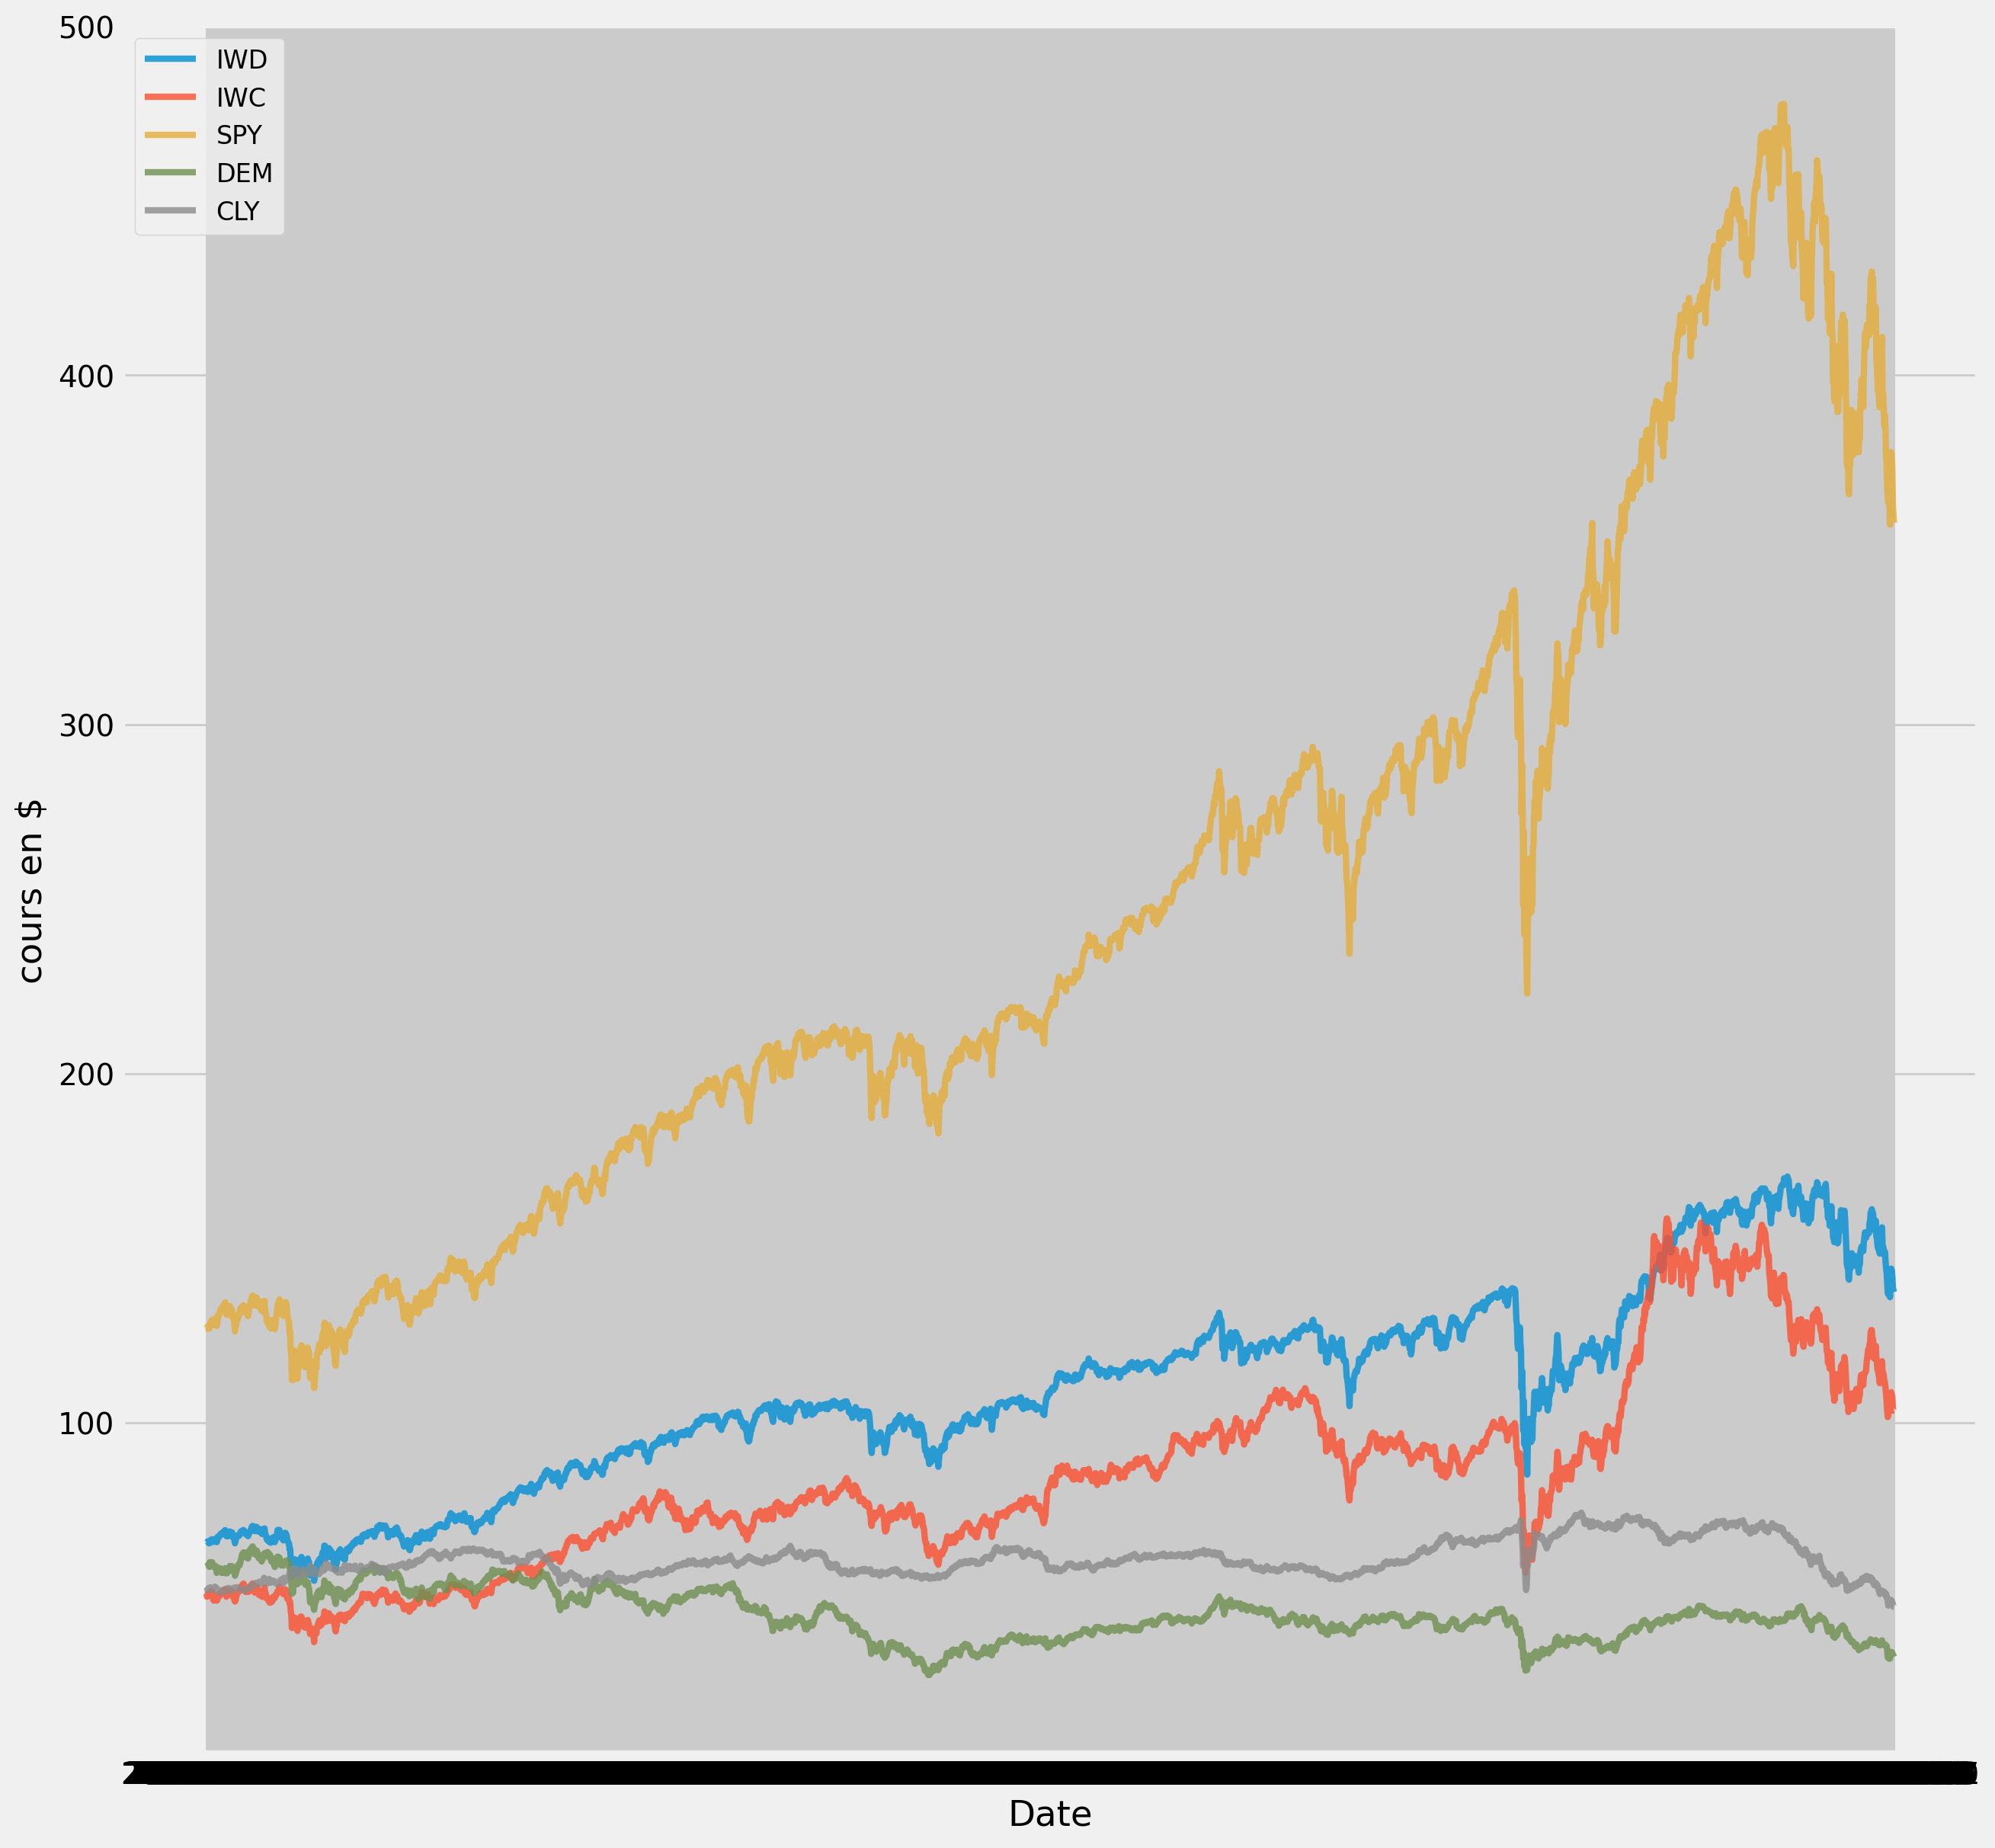

In [83]:
plt.figure(figsize=(14, 14))
for c in table.columns.values:
    plt.plot(table.astype(float).index, table.astype(float)[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Date')
plt.ylabel('cours en $')

Text(0, 0.5, 'Rendements journaliers')

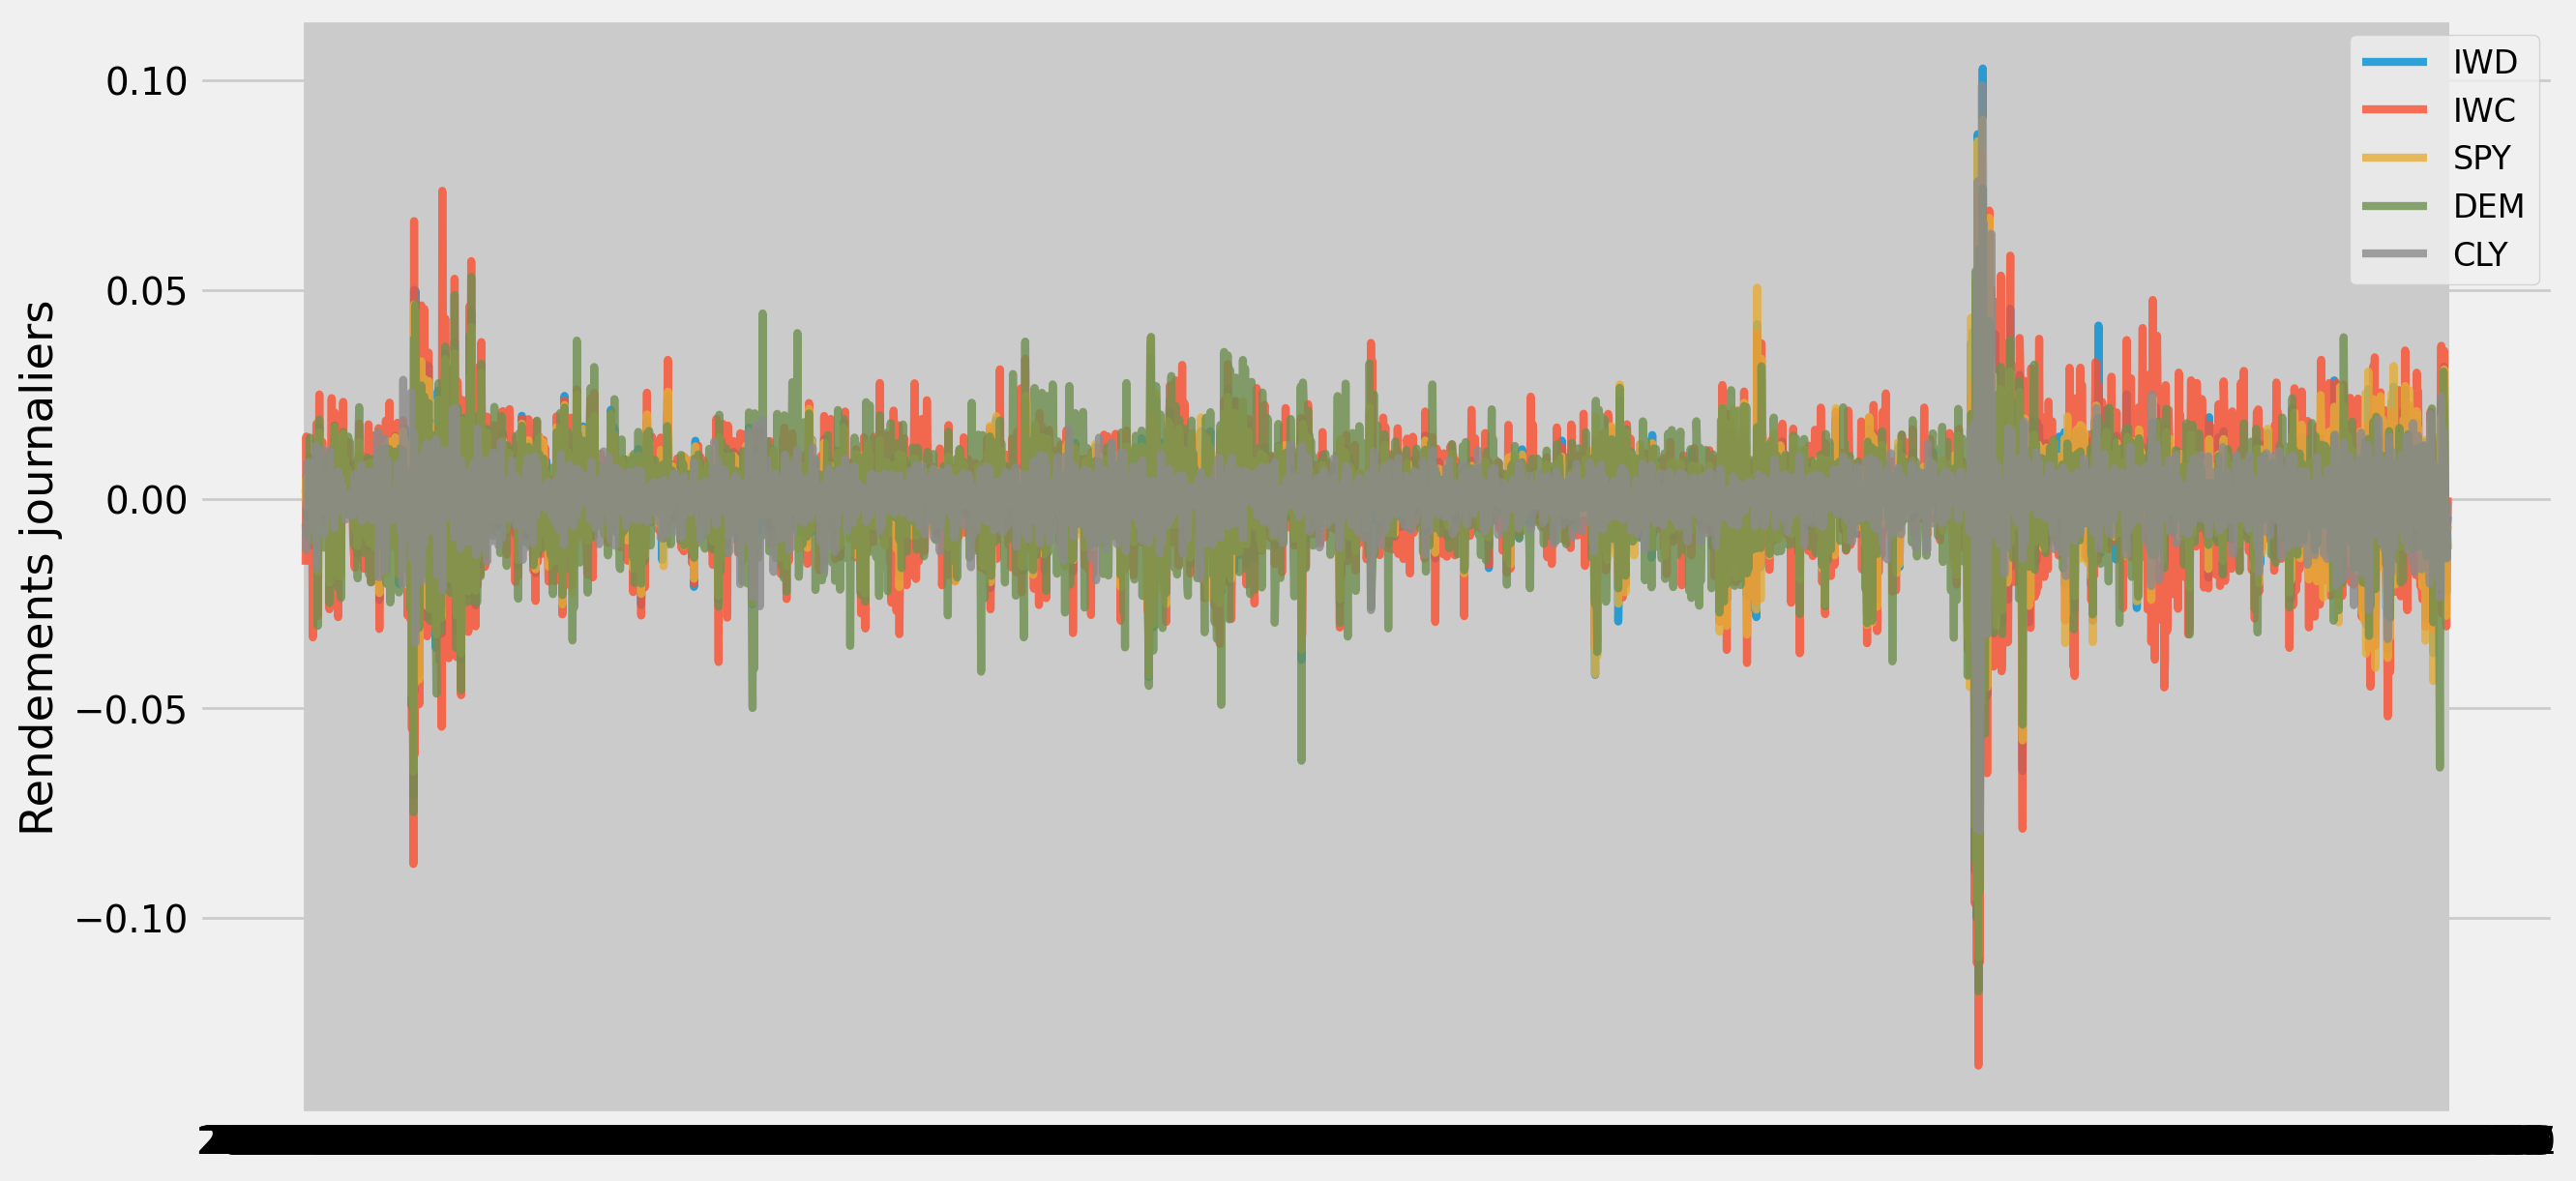

In [59]:
returns = table.astype(float).pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Rendements journaliers')

In [60]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [63]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [72]:
returns = table.astype(float).pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0

In [77]:
def markowitz(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Sharpe Ratio maximal : Allocation de portefeuille\n")
    print ("Rendements annualisés:", round(rp,2))
    print("Volatilité annualisée:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Volatilité minimale : Allocation de portefeuille\n")
    print ("Rendements annualisés:", round(rp_min,2))
    print ("Volatilité annualisée:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Sharpe ratio maximal')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Volatilité minimale')
    plt.title("Simulation d'optimisation de portefeuilles basée sur la frontière d'efficience")
    plt.xlabel('Volatilité annualisée')
    plt.ylabel('Rendements annualisés')
    plt.legend(labelspacing=0.8)



--------------------------------------------------------------------------------
Sharpe Ratio maximal : Allocation de portefeuille

Rendements annualisés: 0.09
Volatilité annualisée: 0.16


             IWD   IWC    SPY   DEM    CLY
allocation  2.62  2.15  83.28  1.78  10.18
--------------------------------------------------------------------------------
Volatilité minimale : Allocation de portefeuille

Rendements annualisés: 0.02
Volatilité annualisée: 0.1


              IWD   IWC   SPY   DEM    CLY
allocation  19.23  3.35  3.61  1.59  72.23


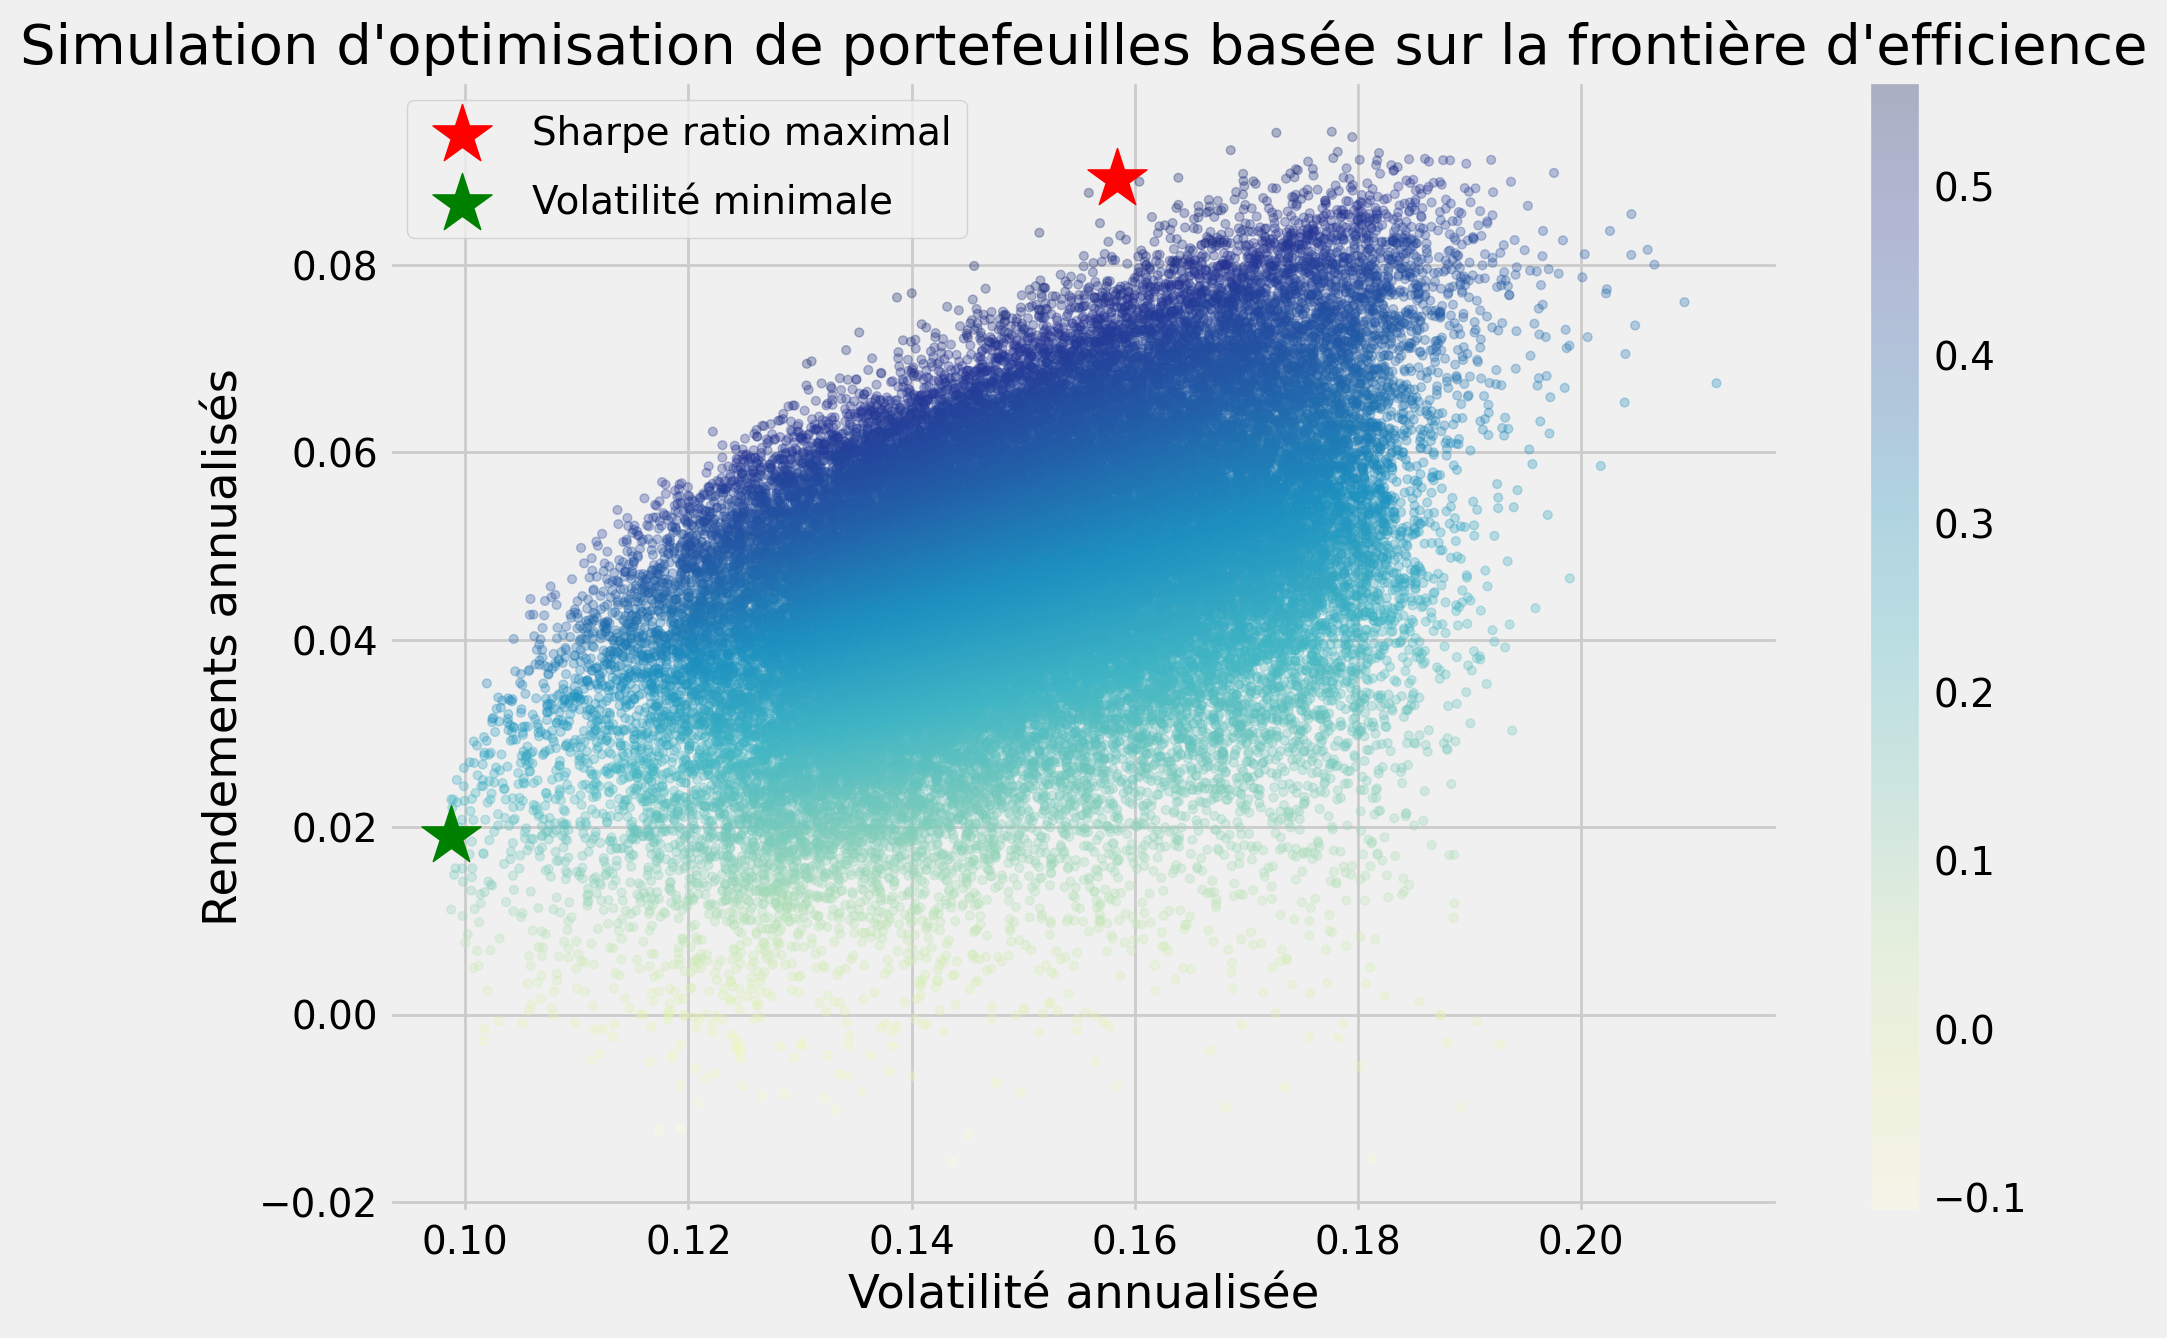

In [78]:
markowitz(mean_returns, cov_matrix, num_portfolios, risk_free_rate)
